# **Deep Learning Framework (Model Training and Evaluation)**

Instructors: Mohammad Reza Mohebbian

**What is PyTorch?**

PyTorch is an open-source Python library for deep learning developed and maintained by Facebook. The project started in 2016 and quickly became a popular framework among developers and researchers.

**What is Torch?**

Torch (Torch7) is an open-source project for deep learning written in C and generally used via the Lua interface. It was a precursor project to PyTorch and is no longer actively developed. 

**How to install pytorch?**

[Official website](https://pytorch.org/)

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Check if it is installed:

In [ ]:
import torch
print(torch.__version__)

1.11.0+cu113


**Some important context in torch:**

**Dataset** : [Documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) 

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import random_split
from pandas import read_csv
# from sklearn.preprocessing import LabelEncoder

# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path, header=None)
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        self.X = (self.X-self.X.mean())/self.X.std()
        # ensure input data is floats
        self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        # self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')-1
        self.y = self.y.reshape((len(self.y), 1))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.2):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

-------------------------------------------

**DataLoader** : [Documentation](https://pytorch.org/docs/stable/data.html) 

In [ ]:
from torch.utils.data import DataLoader

# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

---------------------------------------------------

**Model** : [Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

In [ ]:
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        # kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        # kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8, 1)
        # xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        return X

------------------------------------------------------------


Optimizer and loss : [Documentation](https://pytorch.org/docs/stable/optim.html)

In [ ]:
from torch.optim import SGD, Adam
from torch.nn import BCELoss,KLDivLoss
import numpy as np

# train the model
trajecotry_epchs=[]
def train_model(train_dl, model):
    # define the optimization
    criterion = BCELoss()
    #optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer= Adam(model.parameters(),lr=0.01)
    # enumerate epochs
    for epoch in range(1000):
        trajecotry_loss=[]
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            trajecotry_loss.append(loss.item())
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        trajecotry_epchs.append(np.mean(trajecotry_loss))
    return trajecotry_epchs

In [ ]:
from numpy import vstack
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch import Tensor

# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    f1 = f1_score(actuals, predictions)
    auc= roc_auc_score(actuals,predictions)
    return acc, f1, auc

Main pipeline

In [ ]:
# prepare the data
# https://archive.ics.uci.edu/ml/datasets/Liver+Disorders
path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/liver-disorders/bupa.data'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(6)
# train the model
trajectory_epochs = train_model(train_dl, model)
# evaluate the model
acc, f1 , auc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)
print('F1_score: %.3f' % f1)
print('AUC: %.3f' % auc)
# make a single prediction (expect class=1)
row = [94,65,38,27,17,0]
yhat = predict(row, model)
print('Predicted: %.3f (class=%d)' % (yhat, yhat.round()))

276 69
Accuracy: 0.696
F1_score: 0.747
AUC: 0.682
Predicted: 1.000 (class=1)


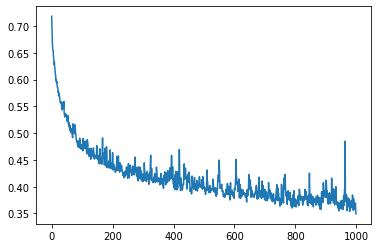

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trajectory_epochs)

**How we can improve it?**



*   Normalization
*   Feature Engineering
*   Learning rate
*   Epoch
*   Loss
  * KL
  * Weighted loss
*   Optimizer
  * Adam
  * AdamW
*   Regularization
  * optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

